In [191]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import os
import CRPS.CRPS as pscore

from eval_utils import aggregate_to_4d_array, compute_kde_results, compute_weighted_data_points, compute_kde, log_transform
from distributions import fit_distributions_to_4d_data, plot_fitted_distributions

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# List RCM outputs

PATH = "/data/hpcdata/users/kenzi22/bcm4rcm/data/processed/"

files = []
for file in os.listdir(PATH):
    if file.endswith(".csv"):
        if '1976' in file:
            files.append(os.path.join(PATH, file))
            
files

['/data/hpcdata/users/kenzi22/bcm4rcm/data/processed/historical_MIROC_1976_2006.csv',
 '/data/hpcdata/users/kenzi22/bcm4rcm/data/processed/historical_MPI_IITM_1976_2006.csv',
 '/data/hpcdata/users/kenzi22/bcm4rcm/data/processed/historical_MPI-REMO2009_1976_2006.csv',
 '/data/hpcdata/users/kenzi22/bcm4rcm/data/processed/historical_NOAA_SMHI1976_2006.csv',
 '/data/hpcdata/users/kenzi22/bcm4rcm/data/processed/historical_CSIRO_1976_2006.csv']

In [29]:
# Read and aggregate each RCM outputs to 4D array
rcm_dict = {}
for file in files:
    df = pd.read_csv(file)
    df = aggregate_to_4d_array(df)
    rcm_dict[file.split('/')[-1].split('_')[1]] = df

In [4]:
# Print shape of RCM dictionary items
for k,v in rcm_dict.items():
    print(k, v.shape)

MIROC (12, 90, 40, 30)
MPI (12, 90, 40, 30)
MPI-REMO2009 (12, 90, 40, 30)
NOAA (12, 90, 40, 30)
CSIRO (12, 90, 40, 30)


In [30]:
# Load weights
weights_path = "/data/hpcdata/users/kenzi22/bcm4rcm/data/weights/wass_arr.npy"
weights_arr = np.load(weights_path)

# Scale weights to sum to 100
weights_arr = (weights_arr/weights_arr.sum(axis=0))*100

In [6]:
# Stack rcm_dict into a 5D array: [rcm, month, lon, lat, points]
rcm_5d = np.stack(list(rcm_dict.values()), axis=0)

In [7]:
# Compute weighted data points
print(rcm_5d.shape, weights_arr.shape)
kde_results = np.zeros((12, 90, 40), dtype=object)

moe_data = compute_weighted_data_points(rcm_5d=rcm_5d, weights_arr=weights_arr)

(5, 12, 90, 40, 30) (5, 12, 90, 40, 1)
Processed indices: (0, 0, 0)
Processed indices: (0, 0, 1)
Processed indices: (0, 0, 2)
Processed indices: (0, 0, 3)
Processed indices: (0, 0, 4)
Processed indices: (0, 0, 5)
Processed indices: (0, 0, 6)
Processed indices: (0, 0, 7)
Processed indices: (0, 0, 8)
Processed indices: (0, 0, 9)
Processed indices: (0, 0, 10)
Processed indices: (0, 0, 11)
Processed indices: (0, 0, 12)
Processed indices: (0, 0, 13)
Processed indices: (0, 0, 14)
Processed indices: (0, 0, 15)
Processed indices: (0, 0, 16)
Processed indices: (0, 0, 17)
Processed indices: (0, 0, 18)
Processed indices: (0, 0, 19)
Processed indices: (0, 0, 20)
Processed indices: (0, 0, 21)
Processed indices: (0, 0, 22)
Processed indices: (0, 0, 23)
Processed indices: (0, 0, 24)
Processed indices: (0, 0, 25)
Processed indices: (0, 0, 26)
Processed indices: (0, 0, 27)
Processed indices: (0, 0, 28)
Processed indices: (0, 0, 29)
Processed indices: (0, 0, 30)
Processed indices: (0, 0, 31)
Processed i

In [188]:
# kde_results = compute_kde_results(rcm_5d=rcm_5d,weights_arr=weights_arr)

In [189]:
# plt.hist(moe_data[1,1,1].flatten(), bins=20);

In [194]:
# Reshape to [month, lon, lat, N * 100], where N is 30
moe_dists = moe_data.reshape(list(moe_data.shape[:3])+[-1])

print(moe_dists.shape)

(12, 90, 40, 3000)


In [148]:
# Fit the distributions to the data
epsilon = 1e-3 # add small value to avoid zeros
fit_results = fit_distributions_to_4d_data(moe_dists[:,:5,:5,:]+epsilon, distributions=None)

In [150]:
# Verify the results
print("Log-normal Parameters: ", fit_results['lognormal']['log_likelihood'].mean())
print("Gamma Parameters: ", fit_results['gamma']['log_likelihood'].mean())
print("Exponential Parameters: ", fit_results['exponential']['log_likelihood'].mean())
print("KDE: ", fit_results['kde']['log_likelihood'].mean())

Log-normal Parameters:  -3268.0362918017363
Gamma Parameters:  -3108.950764437855
Exponential Parameters:  -3998.067820910046
KDE:  -3894.3081690683753


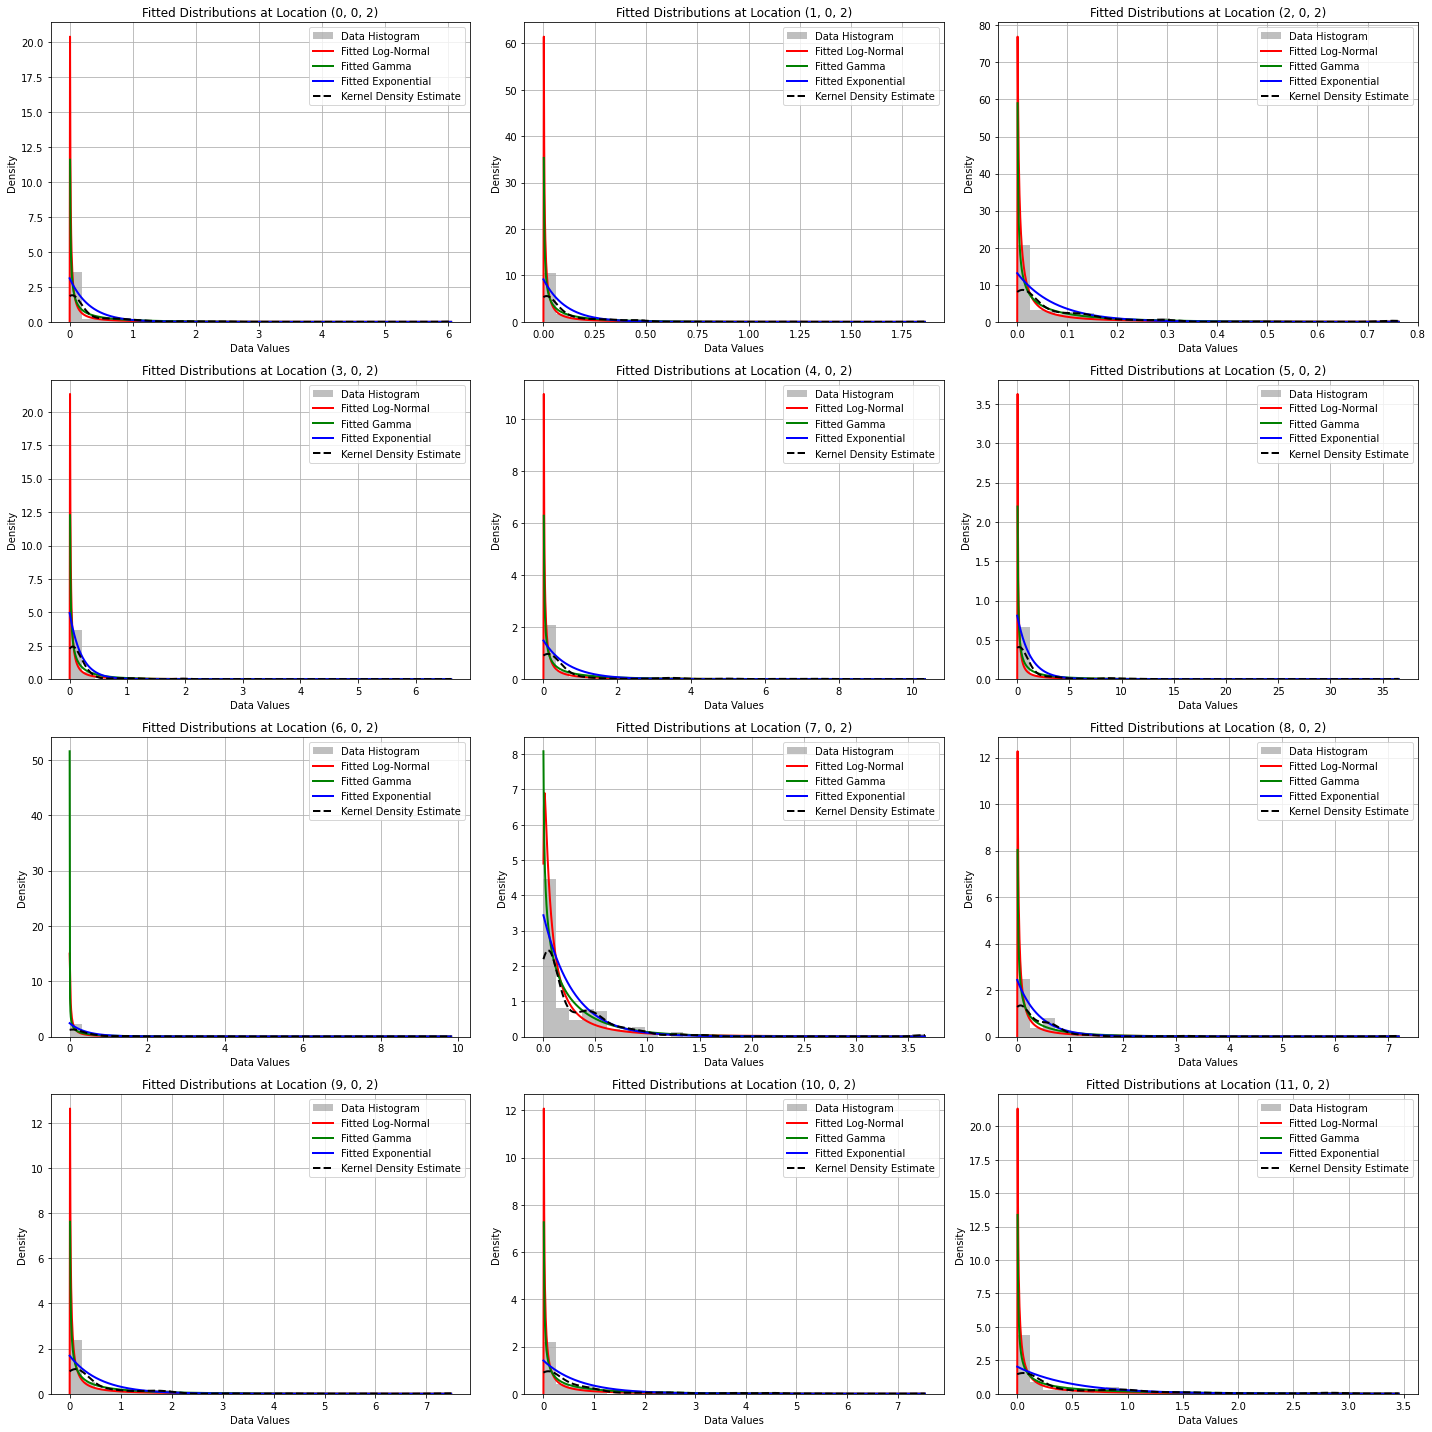

In [187]:
m = np.random.randint(12)
lat = np.random.randint(5)
lon = np.random.randint(5)

fig, axes = plt.subplots(4,3, figsize=(20,20))

for idx, ax in enumerate(axes.flatten()):
    plot_fitted_distributions(data = moe_dists, fitted_results=fit_results, location=(idx,lon,lat), distributions=None, ax=ax)
    
plt.tight_layout()

In [183]:
# Calculate CRPS for 2 empritical CDFS
crps = compute_crps(moe_dists[:,:2,:2,:],moe_dists[:,:2,:2,:]+1)

In [57]:
weights_dict = {}
for k,v in rcm_dict.items():
    weights_dict[k] = np.round(np.random.rand(1),2)

In [58]:
for k,v in rcm_dict.items():
    v = np.repeat(v, int(weights_dict[k]*100), axis=3)
    rcm_dict[k] = v

/var/folders/20/mmwsmqln50jb9dbszgvt2l240000gp/T/ipykernel_95145/1660977929.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = np.repeat(v, int(weights_dict[k]*100), axis=3)


In [59]:
for k,v in rcm_dict.items():
    print(v.shape)

(12, 90, 40, 825)
(12, 90, 40, 1080)
(12, 90, 40, 900)
(12, 90, 40, 810)
(12, 90, 40, 630)


In [60]:
# Creata a 5D array with the values for all the RCMs
rcms = np.concatenate([rcm_dict[i] for i in list(rcm_dict.keys())], axis=-1)

In [261]:
# Apply the log transformation
log_rcms = log_transform(rcms, epsilon=1e-5)

In [262]:
# Compute the KDE
rcms_kde = compute_kde(log_rcms)

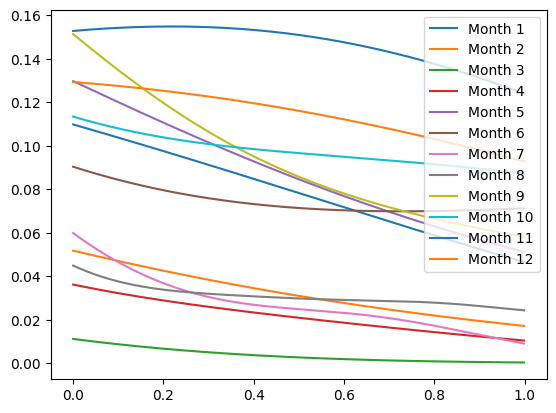

In [263]:
for idx, kde in enumerate(rcms_kde[:, 0, 0]):
    x = np.arange(0, 1, 0.001)
    y = kde.evaluate(x)
    plt.plot(x, y, label=f'Month {idx + 1}')
plt.legend()
plt.show()

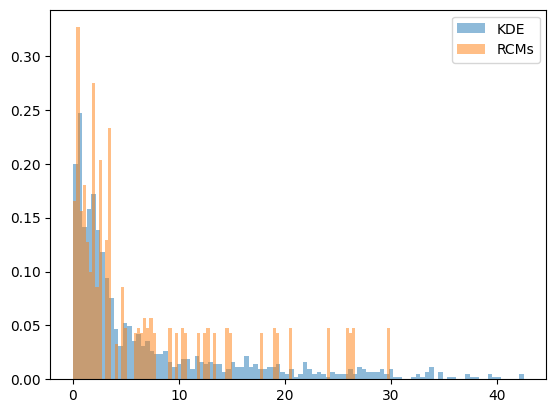

In [264]:
i = 7
j = 5
k = 6

plt.hist(np.exp(rcms_kde[i,j,k].resample(1000)).reshape(-1)-epsilon, bins=100, alpha=0.5, label='KDE', density=True)
plt.hist(np.exp(data[i,j,k,:])-epsilon, bins=100, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()

### APHRODITE

In [4]:
# df = pd.read_csv(files[0])
df = pd.read_csv('/data/hpcdata/users/kenzi22/bcm4rcm/data/aphro_grid.csv')

In [5]:
len(df.lat.unique()), len(df.lon.unique())

(80, 180)

In [6]:
# PATH = "/Users/marron31/repos/bcm4rcm/data/APHRODITE/aphrodite_hma_1951_2016.nc"
PATH = '/data/hpcdata/users/kenzi22/data/APHRODITE/aphrodite_hma_1951_2016.nc'
ds = xr.open_dataset(PATH)

In [7]:
# select data for  period 1961-1975 and spatial extent of interest
# ds_sel = ds.sel(time=slice('1961-01-01', '1975-12-31')).sel(lat=slice(20, 40), lon=slice(60, 105))
ds_sel = ds.sel(time=slice('1961-01-01', '1975-12-31')).sel(lat=slice(df.lat.min(), df.lat.max()), 
                                                            lon=slice(df.lon.min(), df.lon.max())
                                                           )

In [8]:
# Interpolate original dataset to the new coordinates
# interpolated_ds = ds_sel.interp(lat=df.lat.unique(), lon=df.lon.unique(), method='linear', kwargs={"fill_value": "extrapolate"})
interpolated_ds = ds_sel.interp(
    lat=df.lat.unique(),
    lon=df.lon.unique(),
    method='linear',
    kwargs={"bounds_error": True}
)

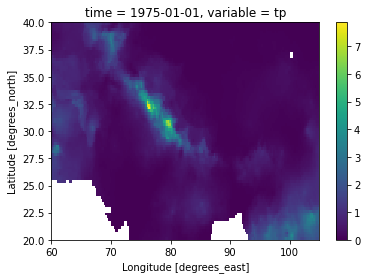

In [9]:
interpolated_ds.sel(time='1975-01-01').to_array().plot()
plt.show()

In [10]:
aphro = interpolated_ds.to_array()

In [13]:
aphro

<xarray.DataArray (variable: 1, time: 180, lat: 80, lon: 180)> Size: 21MB
array([[[[       nan,        nan,        nan, ..., 0.14017579,
          0.16435306, 0.21597821],
         [       nan,        nan,        nan, ..., 0.11352243,
          0.14220431, 0.21315292],
         [       nan,        nan,        nan, ..., 0.07713998,
          0.13876209, 0.20640394],
         ...,
         [0.3914161 , 0.3713595 , 0.35309985, ..., 0.12443686,
          0.12969267, 0.14062871],
         [0.34282297, 0.32463801, 0.2786178 , ..., 0.11694823,
          0.12326334, 0.13290952],
         [0.30447865, 0.25526088, 0.24029404, ..., 0.10833517,
          0.11505885, 0.12311665]],

        [[       nan,        nan,        nan, ..., 1.28230131,
          1.14936233, 1.13777232],
         [       nan,        nan,        nan, ..., 1.42304707,
          1.2059921 , 1.22892392],
         [       nan,        nan,        nan, ..., 1.49431324,
          1.28020954, 1.34327698],
...
         [0.29072884, 0.39424828, 0.415804  , ..., 0.54482841,
          0.533728  , 0.48664281],
         [0.20457061, 0.23772664, 0.26003641, ..., 0.54425681,
          0.53882235, 0.47957137],
         [0.19683143, 0.19128984, 0.18553725, ..., 0.54662746,
          0.54368246, 0.49954316]],

        [[       nan,        nan,        nan, ..., 0.82258308,
          0.57682735, 0.41391   ],
         [       nan,        nan,        nan, ..., 1.00694227,
          0.85650027, 0.63163638],
         [       nan,        nan,        nan, ..., 1.17906892,
          1.04546452, 0.87249964],
         ...,
         [0.29126605, 0.33565125, 0.35060552, ..., 0.03260758,
          0.03064208, 0.02944649],
         [0.23934896, 0.25817695, 0.2703703 , ..., 0.0288721 ,
          0.02786944, 0.026073  ],
         [0.21584173, 0.22152938, 0.22816245, ..., 0.02538174,
          0.02516678, 0.02264284]]]])
Coordinates:
  * time      (time) datetime64[ns] 1kB 1961-01-01 1961-02-01 ... 1975-12-01
  * lat       (lat) float64 640B 20.12 20.38 20.62 20.88 ... 39.38 39.62 39.88
  * lon       (lon) float64 1kB 60.12 60.38 60.62 60.88 ... 104.4 104.6 104.9
  * variable  (variable) object 8B 'tp'

In [275]:
# Step 1: Extract month and year from the 'time' dimension
interpolated_ds['month'] = interpolated_ds['time'].dt.month


In [276]:
tp = np.array(aphro[0,...])
aprho_months = np.array(aphro[1,...])

for month in range(1, 13):
    # Find indices where the second array equals the current month
    indices = np.where(aprho_months == month, 1, np.NaN)
    to_keep = ~np.all(np.isnan(np.multiply(tp,indices)[...]), axis=(1,2))
    filtered_tp = tp[to_keep,...]
    if month == 1:
        filtered_tp_all = filtered_tp
    elif month == 2:
        # print(filtered_tp_all.shape, filtered_tp.shape)
        filtered_tp_all = np.stack((filtered_tp_all, filtered_tp), axis=0)
    else:
        # print(filtered_tp_all.shape, filtered_tp.shape)
        filtered_tp_all = np.concatenate((filtered_tp_all, np.expand_dims(filtered_tp, axis=0)), axis=0)
    

In [277]:
# Transpose the array to have the dimensions in the order (month, lat, lon, year)
aprho = filtered_tp_all.transpose(0, 3, 2, 1)

In [278]:
# Replace NaNs with zeros - for stability in the KDE computation but to be reviewed
aphro_no_nans = np.nan_to_num(aprho, copy=False, nan=0.0, posinf=0.0, neginf=0.0)

In [279]:
# Apply the log transformation
log_aphro = log_transform(aphro_no_nans, epsilon=1e-5)

In [280]:
aphros_kde = compute_kde(log_aphro)

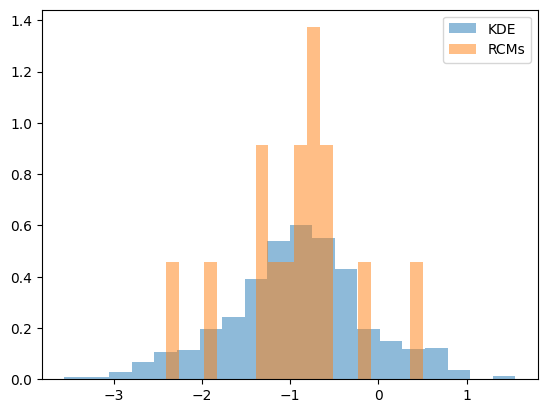

In [281]:
i = 7
j = 30
k = 30

plt.hist(aphros_kde[i,j,k].resample(1000).reshape(-1), bins=20, alpha=0.5, label='KDE', density=True)
plt.hist(log_aphro[i,j,k,:], bins=20, alpha=0.5, label='RCMs', density=True)
plt.legend()
plt.show()

In [285]:
aphros_kde.shape, rcms_kde.shape

((12, 90, 40), (12, 90, 40))

In [288]:
flat_aphros_kde = aphros_kde.reshape(-1)
flat_rcms_kde = rcms_kde.reshape(-1)

In [289]:
from scipy.stats import ks_2samp

In [291]:
def compute_ks_tests(array1, array2):
    assert array1.shape == array2.shape, "Arrays must have the same shape."
    n, m, h = array1.shape
    
    # Initialize an array to store the KS test results (D statistic and p-value for each pair)
    ks_results = np.empty((n, m, h), dtype=[('D', 'f4'), ('p', 'f4')])
    
    for i in range(n):
        for j in range(m):
            for k in range(h):
                # Sample from the KDEs represented by the current cell in each array
                samples1 = sample_from_kde(array1[i, j, k])
                samples2 = sample_from_kde(array2[i, j, k])
                
                # Perform KS test between the two sets of samples
                D, p = ks_2samp(samples1, samples2)
                
                # Store the KS test results
                ks_results[i, j, k] = (D, p)

                print(f'KS test results for cell ({i}, {j}, {k}): D = {D:.4f}, p = {p:.4f}')
    
    return ks_results

def sample_from_kde(kde, n_samples=100, epsilon=1e-5):
    return np.exp(kde.resample(n_samples)).reshape(-1)-epsilon

In [293]:
ks_results = compute_ks_tests(aphros_kde, rcms_kde)

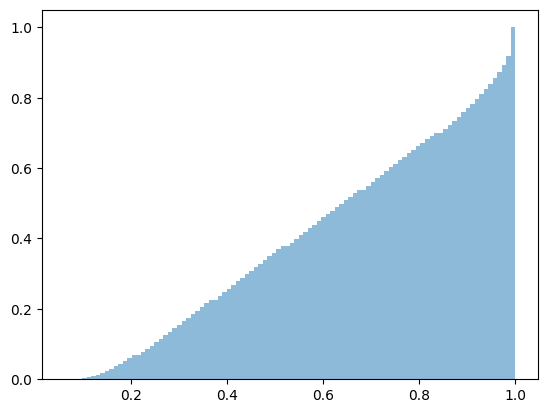

In [318]:
# Apply log transformation: ['MPI', 'CSIRO', 'MPI-REMO2009', 'NOAA', 'MIROC']
log_CSIRO = log_transform(rcm_dict['CSIRO'], epsilon=1e-5)
log_MPI = log_transform(rcm_dict['MPI'], epsilon=1e-5)
log_MPI_REMO2009 = log_transform(rcm_dict['MPI-REMO2009'], epsilon=1e-5)
log_NOAA = log_transform(rcm_dict['NOAA'], epsilon=1e-5)
log_MIROC = log_transform(rcm_dict['MIROC'], epsilon=1e-5)

In [319]:
# KDE computation
kde_CSIRO = compute_kde(log_CSIRO)
kde_MPI = compute_kde(log_MPI)
kde_MPI_REMO2009 = compute_kde(log_MPI_REMO2009)
kde_NOAA = compute_kde(log_NOAA)
kde_MIROC = compute_kde(log_MIROC)

In [320]:
# KS test
ks_results_CSIRO = compute_ks_tests(aphros_kde, kde_CSIRO)
print('Done with CSIRO')
ks_results_MPI = compute_ks_tests(aphros_kde, kde_MPI)
print('Done with MPI')
ks_results_MPI_REMO2009 = compute_ks_tests(aphros_kde, kde_MPI_REMO2009)
print('Done with MPI-REMO2009')
ks_results_NOAA = compute_ks_tests(aphros_kde, kde_NOAA)
print('Done with NOAA')
ks_results_MIROC = compute_ks_tests(aphros_kde, kde_MIROC)
print('Done with MIROC')

Done with CSIRO
Done with MPI
Done with MPI-REMO2009
Done with NOAA
Done with MIROC


In [403]:
ks_results_new = compute_ks_tests(aphros_kde, kde_results)

In [1]:
# histograms with no fill
plt.hist(ks_results['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='Random MoE', histtype='step')
plt.hist(ks_results_new['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='MoE', histtype='step')
plt.hist(ks_results_CSIRO['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='CSIRO', histtype='step')
plt.hist(ks_results_MPI['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='MPI', histtype='step')
plt.hist(ks_results_MPI_REMO2009['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='MPI-REMO2009', histtype='step')
plt.hist(ks_results_NOAA['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='NOAA', histtype='step')
plt.hist(ks_results_MIROC['D'].reshape(-1), bins=100, cumulative=True, density=False, alpha=0.5, label='MIROC', histtype='step')

plt.legend()
plt.show()

NameError: name 'plt' is not defined